<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo/blob/main/Lunar_Crater_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"samihamuntahamahin","key":"3b6d29c9556db74812f31ee98a90662f"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d helodrys/nebula-images -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/helodrys/nebula-images
License(s): MIT
 75% 171M/228M [00:00<00:00, 1.65GB/s]
100% 228M/228M [00:00<00:00, 1.14GB/s]


In [6]:
import os
import shutil
import random

# Paths
DATASET_PATH = "/content/data/Nebulae"   # adjust if different
OUTPUT_PATH = "/content/data/Nebulae/train"

# Classes in dataset
classes = ["Dark Nebula", "Emission Nebula", "Planetary Nebula", "Reflection Nebula", "Supernova Remnants"]

# Make sure output train folder exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Process each class
for cls in classes:
    src_folder = os.path.join(DATASET_PATH, cls)
    dst_folder = os.path.join(OUTPUT_PATH, cls.replace(" ", "_"))  # replace spaces with underscore
    os.makedirs(dst_folder, exist_ok=True)

    # Get list of images
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle to randomize
    random.shuffle(images)

    # Take up to 90 images
    selected_images = images[:90]  # if less than 90, it will just take all available

    # Copy to train folder
    for img in selected_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

    print(f"{cls}: {len(selected_images)} images copied to {dst_folder}")

print(" Train dataset prepared successfully!")


Dark Nebula: 69 images copied to /content/data/Nebulae/train/Dark_Nebula
Emission Nebula: 90 images copied to /content/data/Nebulae/train/Emission_Nebula
Planetary Nebula: 90 images copied to /content/data/Nebulae/train/Planetary_Nebula
Reflection Nebula: 57 images copied to /content/data/Nebulae/train/Reflection_Nebula
Supernova Remnants: 84 images copied to /content/data/Nebulae/train/Supernova_Remnants
 Train dataset prepared successfully!


In [7]:
train_dir = "/content/data/Nebulae/train"
test_dir   = "/content/data/Nebulae/Images(Test)"
val_dir  = "/content/data/Nebulae/Validation"

# **Data Visualization**

Classes: ['Dark_Nebula', 'Reflection_Nebula', 'Supernova_Remnants', 'Planetary_Nebula', 'Emission_Nebula']


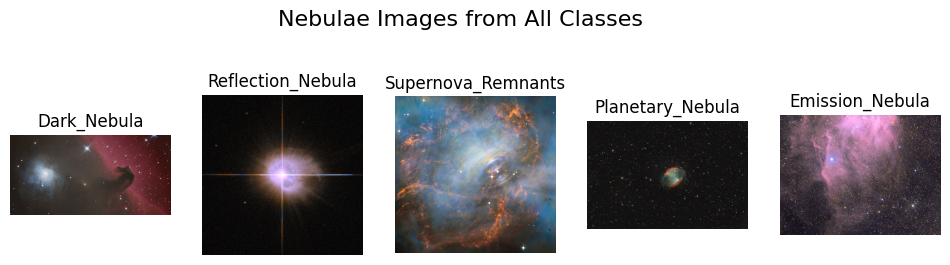

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

classes = os.listdir(train_dir)
print("Classes:", classes)

# Show one random image from each class
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)

    # Pick a random image from that class
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    # Read image
    img = mpimg.imread(img_path)

    # Plot
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Nebulae Images from All Classes", fontsize=16)
plt.show()

/tmp/ipython-input-1213128879.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="count", data=df, palette="pastel")


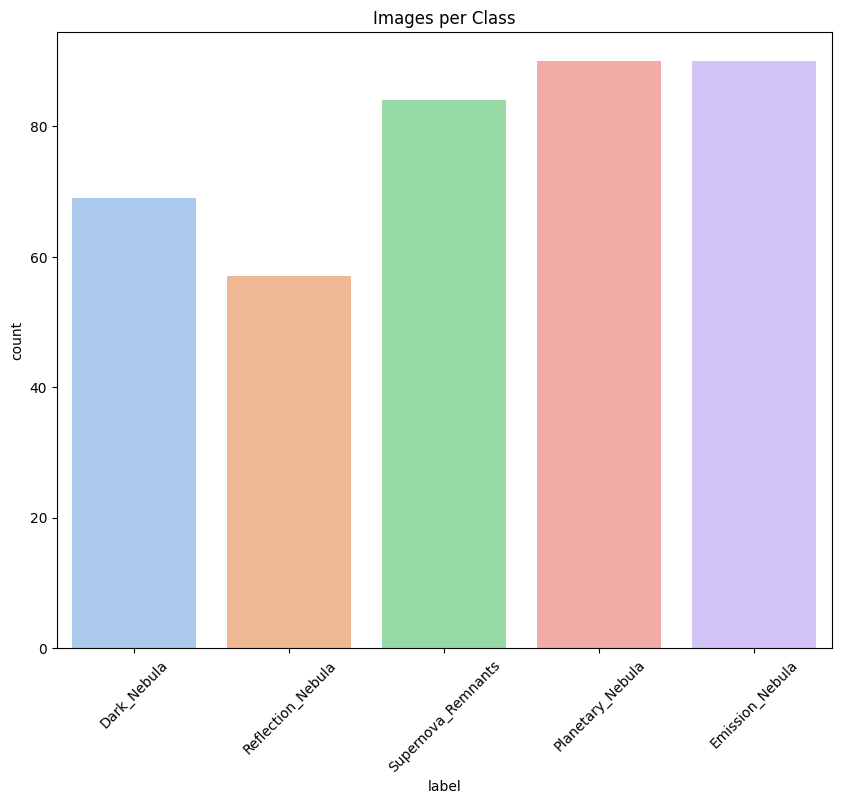

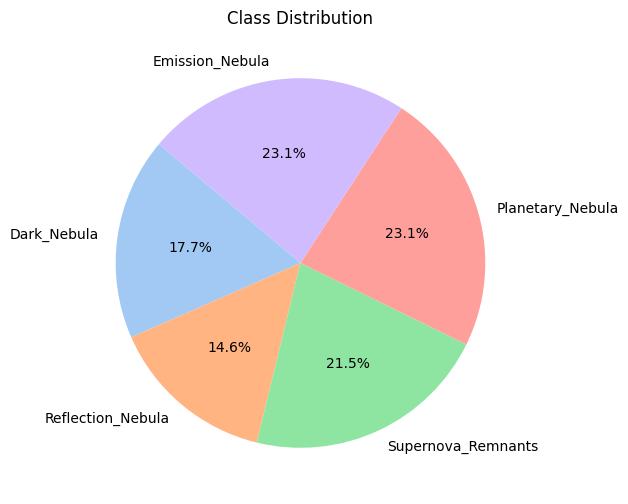

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count images per class
df = pd.DataFrame([(cls, len(os.listdir(os.path.join(train_dir, cls))))
                   for cls in os.listdir(train_dir)], columns=["label", "count"])

# Bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x="label", y="count", data=df, palette="pastel")
plt.xticks(rotation=45); plt.title("Images per Class"); plt.show()

# Pie chart
df.set_index("label")["count"].plot(kind="pie", autopct="%1.1f%%",
                                    startangle=140, figsize=(6,6),
                                    colors=sns.color_palette("pastel"))
plt.title("Class Distribution"); plt.ylabel(""); plt.show()


# **Encode Labels & Balance Dataset**

In [10]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import os

#Encoding the labels into the numbers
encoder = LabelEncoder()
df["Label_num"] = encoder.fit_transform(df["label"])

# Create a list of image paths and their corresponding labels
image_paths = []
labels_num = []
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img_name))
        labels_num.append(encoder.transform([cls])[0])

# Create a DataFrame with image paths and numerical labels
image_df = pd.DataFrame({"image_path": image_paths, "label_num": labels_num})

#Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(image_df[["image_path"]], image_df["label_num"])

#Creating the new balanced dataFrame
df_balanced = pd.DataFrame({"image_path":X["image_path"] , "label_num":y})

print("\nBalanced class counts:")
print(df_balanced["label_num"].value_counts())


Balanced class counts:
label_num
0    90
3    90
4    90
2    90
1    90
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split

# Ensure label_num is integer type for sparse_categorical_crossentropy
df_balanced['label_num'] = df_balanced['label_num'].astype(str)

train_df, temp_df = train_test_split(df_balanced, train_size=0.8, shuffle=True,
                                     stratify=df_balanced['label_num'], random_state=42)

valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True,
                                     stratify=temp_df['label_num'], random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

Train size: (360, 2)
Validation size: (45, 2)
Test size: (45, 2)


# **Data Augmentation**

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label_num',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label_num',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='label_num',
                                      target_size=img_size, class_mode='sparse',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 360 validated image filenames belonging to 5 classes.
Found 45 validated image filenames belonging to 5 classes.
Found 45 validated image filenames belonging to 5 classes.


# **Create EfficientNetB0 Model , Train Model, Plot Accuracy & Loss, Evaluate on Test Set**

In [21]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_efficientnet_simple(input_shape=(224,224,3), num_classes=5):
    inputs = Input(shape=input_shape)

    # Pretrained EfficientNetB0 without top layers
    base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze most layers
    for layer in base.layers[:-10]:
        layer.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Create and compile model
model = create_efficientnet_simple(num_classes=5) # Changed num_classes to 10
model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,840,104 (18.46 MB)

 Trainable params: 1,682,741 (6.42 MB)

 Non-trainable params: 3,157,363 (12.04 MB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training if val_loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_efficientnet_model.h5',  # File name to save
    monitor='val_accuracy',         # Monitor validation accuracy
    save_best_only=True,            # Save only the best model
    mode='max',                     # Higher accuracy is better
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5772 - loss: 1.1380
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_efficientnet_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5787 - loss: 1.1369 - val_accuracy: 0.6667 - val_loss: 1.1599
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5973 - loss: 1.0124
Epoch 2: val_accuracy improved from 0.66667 to 0.73333, saving model to best_efficientnet_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5947 - loss: 1.0176 - val_accuracy: 0.7333 - val_loss: 1.0958
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6079 - loss: 1.0048
Epoch 3: val_accuracy improved from 0.73333 to 0.75556, saving model to best_efficientnet_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6073 - loss: 1.0046 - val_accuracy: 0.7556 - val_loss: 1.0419
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6502 - loss: 0.9462
Epoch 4: val_accuracy improved from 0.75556 to 0.80000, saving model to best_efficientnet_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6508 - loss: 0.9433 - val_accuracy: 0.8000 - val_loss: 0.9893
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6253 - loss: 0.9377
Epoch 5: val_accuracy did not improve from 0.80000
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6274 - loss: 0.9336 - val_accuracy: 0.7333 - val_loss: 0.9461
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7160 - loss: 0.8201
Epoch 6: val_accuracy did not improve from 0.80000
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7154 - loss: 0.8227 - val_accuracy: 0.7333 - val_loss: 0.8978
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6564 - loss: 0.8568
Epoch 7: val_accuracy did not improve from 0.80000
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6565 - loss: 0.8584 - val_accuracy: 0.7556 - val_loss: 0.8552
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6838 - loss: 0.8151
Epoch 8: val_accuracy did not improve from 0.80000
12/1

In [24]:
from tensorflow.keras.models import load_model
best_model = load_model('best_efficientnet_model.h5')

In [25]:
# Evaluate on the test generator
loss, accuracy = model.evaluate(test_gen, verbose=1)

print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.7537 - loss: 0.6452
Final Test Accuracy: 75.56%
Final Test Loss: 0.6403


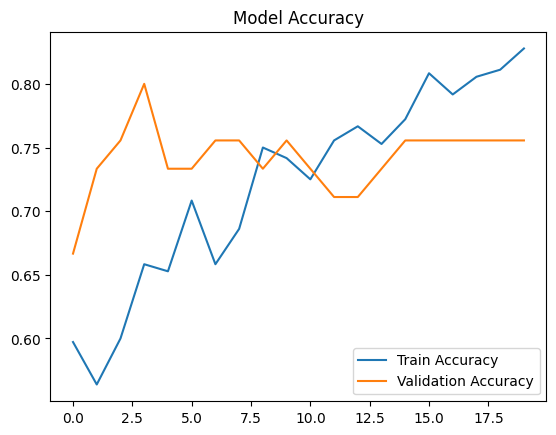

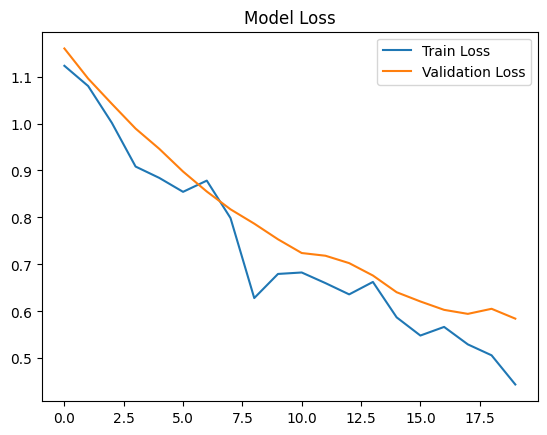

In [26]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      0.33      0.50         9
           2       0.73      0.89      0.80         9
           3       0.78      0.78      0.78         9
           4       0.64      1.00      0.78         9

    accuracy                           0.76        45
   macro avg       0.80      0.76      0.74        45
weighted avg       0.80      0.76      0.74        45



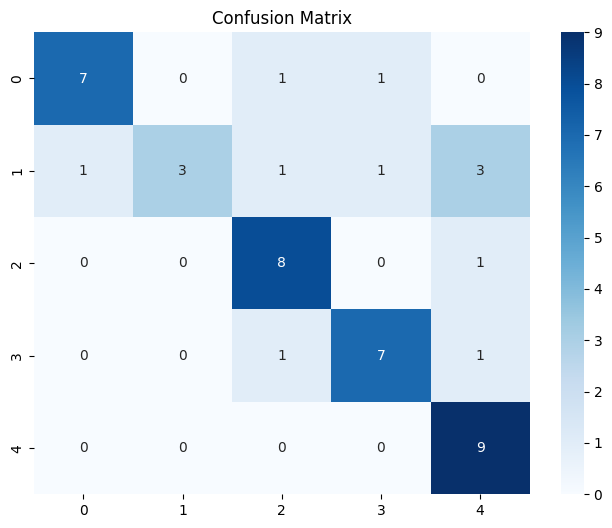

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels from test generator
y_true = test_gen.classes

# Predictions
y_pred = np.argmax(model.predict(test_gen), axis=1) #argmax finds the index of the largest value in an array

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()